In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [2]:
#Liquid properties
rho = 1e3
mu = 8.9e-4
sigma=0.072

#Ambient COnditions
p_atm = 1e5
p_v = 2330

#Polytropic coeff
gamma=1.33

In [3]:
#initial Condition
R_0 = 2e-6
u_0 = 0

In [4]:
#partial pressure of air at eqb
p_g0 = p_atm + 2 * sigma/R_0 - p_v

In [5]:
#pressure at infty as a function of time
#6 cycles of sine waves with a gaussian envelope
p_a = 1.2*p_atm
omega_N = (1/R_0)*np.sqrt(3*gamma*p_g0/rho-2*sigma/R_0/rho);
omega = 2*omega_N;
t0 = 3*2*np.pi/omega
def p_infty (t):
    p_it = p_atm - p_a * np.sin(omega*t)*np.exp(-1.5*(t-t0)**2/(t0**2))
    return p_it

def dpinfty_dt(t):
    return (-p_a*(omega*np.cos(omega*t) + (3*(t-t0)/t0**2)*np.sin(omega*t))*np.exp(-1.5*(t-t0)**2/(t0**2)));

#partial pressure of air as a function of R
def p_gas(R):
    p_g = p_g0*np.power(R_0/R, 3*gamma);
    return p_g

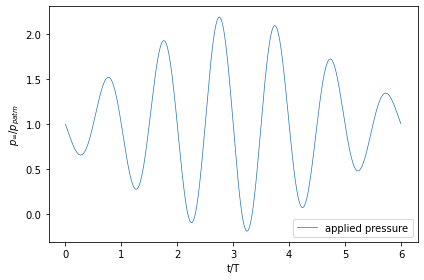

In [6]:
#plot p_infty(t) vs t
tsample = np.arange(0, 2*t0, t0/1000)
psample = p_infty(tsample)
fig, ax1 = plt.subplots()

ax1.set_xlabel("t/T")
ax1.set_ylabel("$p_\infty$/$p_{patm}$")
ax1.plot(tsample/(2*np.pi/omega), psample/p_atm, linewidth = 0.7, label = "applied pressure")

ax1.legend(loc = "lower right")

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [7]:
#d/dt (x) = equation(x,t)
def RP(x, t):
    (R,u) = x;
    udot = (p_gas(R)+p_v-p_infty(t)-2*sigma/R-4*mu*u/R)/(R*rho)-3*u**2/(2*R)
    return (u, udot)

In [8]:
#speed of sound at ambient
C0 = 1450;

#Keller - Miksis
def KM(x, t):
    (R,u) = x; 
    p_L = p_gas(R) + p_v -2*sigma/R-4*mu*u/R; #p_l(r,t) at r=R
    dpL_dt_res = -3*gamma*p_gas(R)*u/R  +  2*sigma*u/R  +  4*mu*u**2/R**2; #dpl_dt_res = dpL_dt - (-4*mu*udot/R)
    udot = ( (1+u/C0)*(p_L-p_infty(t))/rho + R*(dpL_dt_res - dpinfty_dt(t))/(rho*C0) - 1.5*(1-u/3/C0)*u**2 )/ (1-u/C0 + 4*mu/(C0*rho*R))/R;
    return (u, udot)

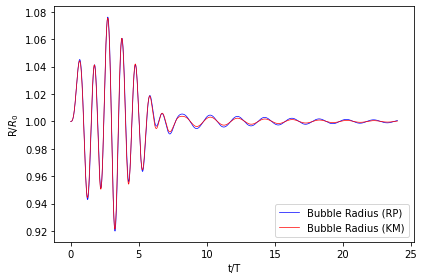

In [9]:
time = np.arange(0, 24*2*np.pi/omega, 0.000000000025)
#time = np.arange(0, 6*2*np.pi/omega, 0.00000000025)
#solving ODE by RP
R_RP = odeint(RP, [R_0, u_0], time)
U_RP = R_RP[:,1]
R_RP = R_RP[:,0]/R_0
#solving ODE by KM
R_KM = odeint(KM, [R_0, u_0], time)
U_KM = R_KM[:,1]
R_KM = R_KM[:,0]/R_0
#plot results

fig, ax1 = plt.subplots()

ax1.set_xlabel("t/T")
ax1.set_ylabel("R/$R_0$")
ax1.plot(time/(2*np.pi/omega), R_RP, linewidth = 0.7, label = "Bubble Radius (RP)", color = 'blue')
ax1.plot(time/(2*np.pi/omega), R_KM, linewidth = 0.7, label = "Bubble Radius (KM)", color = 'red')

ax1.legend(loc = "lower right")

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [10]:
#Fourier Analysis
from numpy.fft import fft, ifft, fftshift, fftfreq

def fft_transform(x, y):
    """
    Plot y(x) and its transform.
    
    y can be real or complex.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    fy = fftshift(fft(y))
    freqs = fftshift(fftfreq(len(x), d=(x[1] - x[0])))    

    return fy, freqs 

def show_transform(x, y):
    """
    Plot y(x) and its transform.
    
    y can be real or complex.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    fy = fftshift(fft(y))
    freqs = fftshift(fftfreq(len(x), d=(x[1] - x[0])))    
    fig, axs = plt.subplots(nrows=2, constrained_layout=True)

    for ax in axs:
        ax.margins(x=0.05, y=0.1)
        ax.grid(True)
        ax.locator_params(symmetric=True)
        # (Line above doesn't seem to be working as expected...)
            
    ax = axs[0]
    if y.dtype.kind == 'c':
        ax.plot(x, y.real, 'r+', x, y.imag, 'bx')
    else:
        ax.plot(x, y, 'k.')
    ax.set_xlabel("Time")
    
    ax = axs[1]
    ax.plot(freqs, np.abs(fy), 'ko', mfc='none', label='amp')
    ax.plot(freqs, fy.real, 'r+', label='real')
    ax.plot(freqs, fy.imag, 'bx', label='imag')

    ax.set_xlabel("Frequency, cycles per unit time")
    ax.legend(loc="best", 
                  numpoints=1,
                  fontsize='small')
    

    return fig, axs 

In [11]:
#Forcing frequency 
omega

24596408.274380226

In [12]:
#natural frequency
omega_N

12298204.137190113

In [13]:
#resonance frequency
omega_P= np.sqrt(omega_N**2 - 8*mu**2/rho**2/R_0**4);
omega_P/omega_N

0.9986898494135765

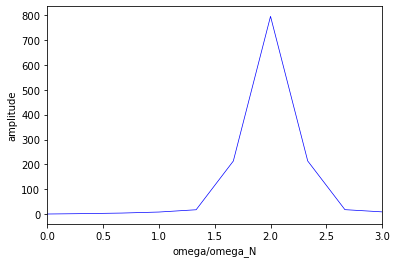

In [14]:
#pressure forcing
fy, freqs = fft_transform(tsample*omega_N, psample/p_atm-1)

fig, ax1 = plt.subplots()
ax1.set_xlabel("omega/omega_N")
ax1.set_ylabel("amplitude")
ax1.plot(freqs*2*np.pi, np.abs(fy), linewidth = 0.7, label = "energy spectrum of input acoustc wave", color = 'blue')
plt.xlim(0,3);
plt.show() #expect amplitude max at omega/omega_N=2

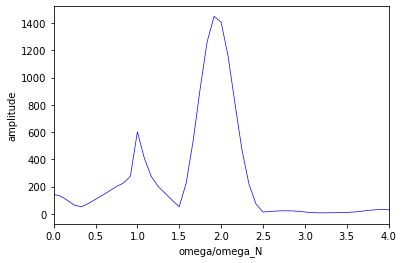

In [15]:
#fourier of radius
fy, freqs = fft_transform(time*omega_N, R_KM-1)

fig, ax1 = plt.subplots()
ax1.set_xlabel("omega/omega_N")
ax1.set_ylabel("amplitude")
ax1.plot(freqs*2*np.pi, np.abs(fy), linewidth = 0.7, label = "x(omega) from (R(t)/R0 -1 )", color = 'blue')
plt.xlim(0,4);
plt.show() #expect amplitude max ?

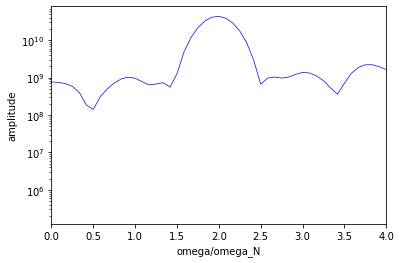

In [16]:
#energy spectrum of reflecting wave is rho*const*( 2*(Rdot**2)*R + (R**2)*Rdotdot )

Energy = [];
Energy.append(0.)
#udot = [];
r, = np.shape(R_KM)
for i in np.arange(1, r):
    t = time[i]
    u = U_KM[i]
    R = R_KM[i]
    u,a = KM((R,u), t)
    Energy.append(2*u**2*R+R**2*a)

#energy spectrum
fy, freqs = fft_transform(time*omega_N, Energy) 
fig, ax1 = plt.subplots()
ax1.set_xlabel("omega/omega_N")
ax1.set_ylabel("amplitude")
ax1.semilogy(freqs*2*np.pi, np.abs(fy), linewidth = 0.7, label = "x(omega) from (R(t)/R0 -1 )", color = 'blue')
plt.xlim(0,4);
plt.show() #expect amplitude max ?